(28, 28)
5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


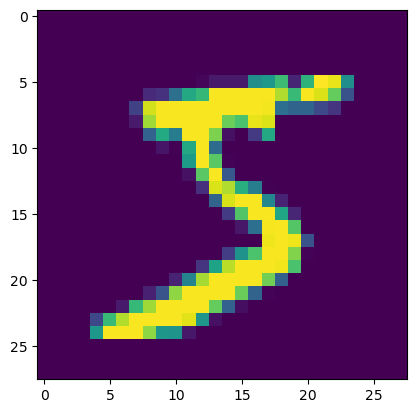

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize to [0, 1]

y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=10)

index =0
print(x_train[0].shape)
plt.imshow(x_train[0])
print(y_train[index])
print(y_train_onehot[index])


In [2]:
input_shape =(28,28,1)

In [3]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten,MaxPooling2D,Dropout


teacher_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),  # Conv Layer 1
    MaxPooling2D((2, 2)),                                           # Max Pooling Layer 1
    Conv2D(64, (3, 3), activation='relu'),                          # Conv Layer 2
    MaxPooling2D((2, 2)),                                           # Max Pooling Layer 2
    Flatten(), 
    Dense(256, activation='relu'),                                                      # Flatten Layer
    Dense(128, activation='relu'),                                  # Fully Connected Layer
    Dense(10, activation='softmax')      
])
teacher_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 256)               4

In [4]:
from tensorflow.keras.optimizers import Adam
teacher_model.compile(loss='categorical_crossentropy',
              optimizer =Adam(),
              metrics = ['accuracy'])


In [5]:
history = teacher_model.fit(
    x=x_train,
    y= y_train_onehot,
    validation_data = (x_test,y_test_onehot),
    batch_size = 16,
    epochs = 5,
    verbose =1
)

Epoch 1/5
3750/3750 [==============================] - 26s 4ms/step - loss: 0.1160 - accuracy: 0.9643 - val_loss: 0.0380 - val_accuracy: 0.9865
Epoch 2/5
3750/3750 [==============================] - 13s 4ms/step - loss: 0.0446 - accuracy: 0.9865 - val_loss: 0.0331 - val_accuracy: 0.9892
Epoch 3/5
3750/3750 [==============================] - 24s 6ms/step - loss: 0.0306 - accuracy: 0.9906 - val_loss: 0.0423 - val_accuracy: 0.9875
Epoch 4/5
3750/3750 [==============================] - 51s 13ms/step - loss: 0.0233 - accuracy: 0.9928 - val_loss: 0.0443 - val_accuracy: 0.9859
Epoch 5/5
3750/3750 [==============================] - 24s 6ms/step - loss: 0.0172 - accuracy: 0.9948 - val_loss: 0.0342 - val_accuracy: 0.9916


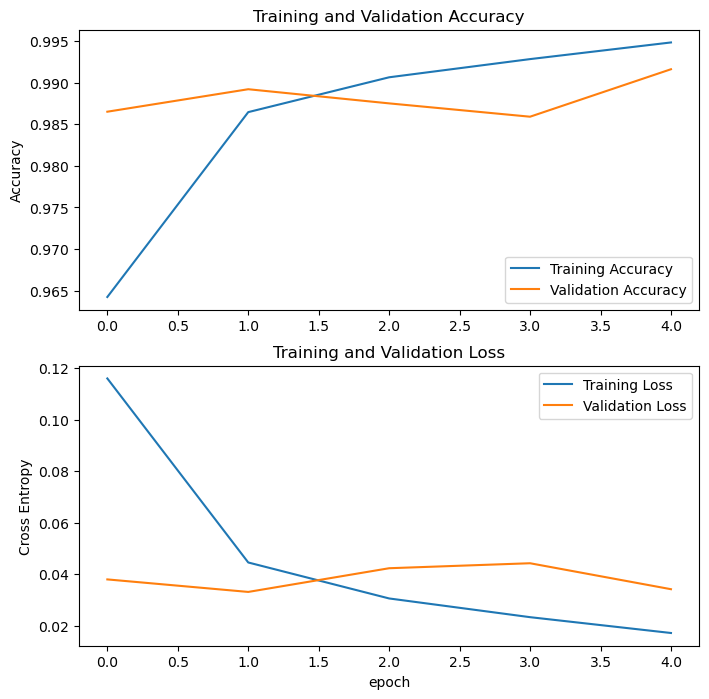

In [6]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')

plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [8]:
student_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),  # Conv Layer 1
    MaxPooling2D((2, 2)),                                           # Max Pooling Layer 1
    Conv2D(64, (3, 3), activation='relu'),                          # Conv Layer 2
    MaxPooling2D((2, 2)),                                           # Max Pooling Layer 2
    Flatten(), 
                                                         # Flatten Layer
    Dense(16, activation='relu'),                                  # Fully Connected Layer
    Dense(10, activation='softmax')      
])
student_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 1600)              0         
                                                                 
 dense_5 (Dense)             (None, 16)               

In [16]:
def distillation_loss(y_true,y_pred,teacher_pred, temperature=5):
    teacher_pred_scaled = tf.nn.softmax(teacher_pred/temperature)

    student_pred_scaled = tf.nn.softmax(y_pred/temperature)

    kd_loss = tf.reduce_mean(
        tf.keras.losses.categorical_crossentropy(teacher_pred_scaled,student_pred_scaled)
    )

    ce_loss = tf.reduce_mean(
        tf.keras.losses.categorical_crossentropy(y_true,y_pred)
    )

    return kd_loss * 0.5 + ce_loss * 0.5

In [19]:
epochs = 5
batch_size = 8
step_per_epoch = int(len(x_train)/batch_size)
print(len(x_train))

student_optimizer = Adam()
for epoch in range(epochs):
    for i in range(step_per_epoch):
        start = i*batch_size
        end = start + batch_size
        x_batch = x_train[start:end]
        y_batch = y_train_onehot[start:end ]

        with tf.GradientTape() as tape:
            predictions = student_model(x_batch,training =True)
            teacher_predictions = teacher_model(x_batch,training = False)
            loss = distillation_loss(y_true=y_batch,
                                     y_pred=predictions,
                                     teacher_pred=teacher_predictions,
                                       temperature=5)

        gradients = tape.gradient(loss,student_model.trainable_variables)
        student_optimizer.apply_gradients(zip(gradients,student_model.trainable_variables))

        if i%200 == 0:
            print(f"Batch {i}/{step_per_epoch}, loss : {loss.numpy()}")


60000
Batch 0/7500, loss : 1.1695785522460938
Batch 200/7500, loss : 1.6845428943634033
Batch 400/7500, loss : 1.1629725694656372
Batch 600/7500, loss : 1.1684637069702148
Batch 800/7500, loss : 1.1838048696517944
Batch 1000/7500, loss : 1.1504390239715576
Batch 1200/7500, loss : 1.1524169445037842
Batch 1400/7500, loss : 1.1597025394439697
Batch 1600/7500, loss : 1.150525689125061
Batch 1800/7500, loss : 1.1925938129425049
Batch 2000/7500, loss : 1.1521239280700684
Batch 2200/7500, loss : 1.1648237705230713
Batch 2400/7500, loss : 1.1509331464767456
Batch 2600/7500, loss : 1.1508527994155884
Batch 2800/7500, loss : 1.17299222946167
Batch 3000/7500, loss : 1.1543030738830566
Batch 3200/7500, loss : 1.1514934301376343
Batch 3400/7500, loss : 1.152574896812439
Batch 3600/7500, loss : 1.2025887966156006
Batch 3800/7500, loss : 1.1506407260894775
Batch 4000/7500, loss : 1.1505763530731201
Batch 4200/7500, loss : 1.153354287147522
Batch 4400/7500, loss : 1.3001099824905396
Batch 4600/7500, 

KeyboardInterrupt: 

In [ ]:
test_acc = tf.keras.metrics.categorical_accuracy(y_test_onehot,student_model(x_test))
tf.reduce_mean(test_acc)